# **Employee Salary Prediction using adult.csv**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import joblib

Step-1 Load Data



In [3]:
data = pd.read_csv("/content/adult 3.csv")
print("Initial Shape:", data.shape)
display(data.head())

Initial Shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Step-2 Handle Missing and Irrelevant Values

In [4]:
data.occupation.replace({'?': 'others'}, inplace=True)
data.workclass.replace({'?': 'notListed'}, inplace=True)
data = data[~data['workclass'].isin(['Without-pay', 'Never-worked'])]
data = data[~data['education'].isin(['Preschool', '1st-4th', '5th-6th'])]
data.drop(columns=['education'], inplace=True)
data = data[(data['age'] >= 17) & (data['age'] <= 75)]
print("Cleaned Shape:", data.shape)

Cleaned Shape: (47619, 14)


/tmp/ipython-input-4-1269899256.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.occupation.replace({'?': 'others'}, inplace=True)
/tmp/ipython-input-4-1269899256.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

Step-3 Encode Categorical Features

In [5]:
encoder = LabelEncoder()
for col in ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']:
    data[col] = encoder.fit_transform(data[col])

Step-4 Define Features and Target

In [6]:
x = data.drop(columns=['income'])
y = LabelEncoder().fit_transform(data['income'])

Step-5 Scale and Split Data

In [7]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=23, stratify=y)


Step-6 Train Models

In [8]:
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000)
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(5,2), max_iter=2000)

knn.fit(x_train, y_train)
lr.fit(x_train, y_train)
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=2000)

Step-7 Predict and Evaluate

In [9]:
pred_knn = knn.predict(x_test)
pred_lr = lr.predict(x_test)
pred_mlp = mlp.predict(x_test)

print("KNN Accuracy:", accuracy_score(y_test, pred_knn))
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr))
print("MLP Accuracy:", accuracy_score(y_test, pred_mlp))

KNN Accuracy: 0.8182486350272995
Logistic Regression Accuracy: 0.8205585888282234
MLP Accuracy: 0.8389332213355732


Step-8 Bar Plot for Accuracy Comparison

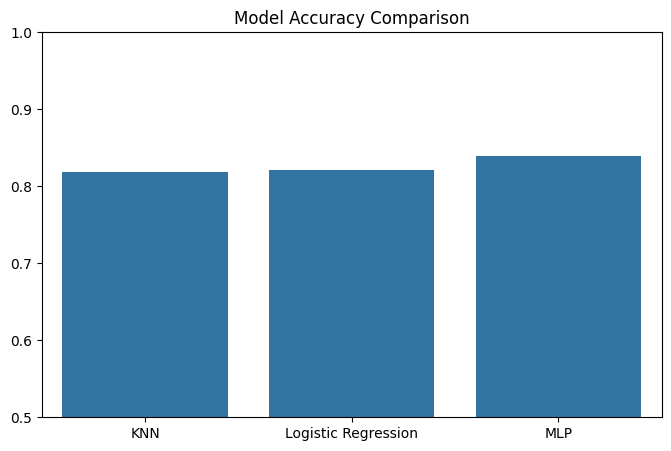

In [10]:
models = ['KNN', 'Logistic Regression', 'MLP']
accuracies = [
    accuracy_score(y_test, pred_knn),
    accuracy_score(y_test, pred_lr),
    accuracy_score(y_test, pred_mlp)
]
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylim(0.5, 1)
plt.show()

Step-9 Save best model (MLP assumed best)

In [11]:
joblib.dump(mlp, "model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

Step-10 Setup Gradio UI

In [12]:
!pip install -q gradio

import gradio as gr

model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")

def predict_salary(age, workclass, fnlwgt, education_num, marital_status,
                   occupation, relationship, race, gender, capital_gain,
                   capital_loss, hours_per_week, native_country):

    input_data = pd.DataFrame([[
        age, workclass, fnlwgt, education_num, marital_status, occupation,
        relationship, race, gender, capital_gain, capital_loss,
        hours_per_week, native_country
    ]], columns=x.columns)

    input_scaled = scaler.transform(input_data)
    prob = model.predict_proba(input_scaled)[0][1]
    label = ">50K" if prob > 0.5 else "<=50K"
    return f"{label} (Confidence: {round(prob*100, 2)}%)"


Step-11 Launch Gradio App

In [ ]:
gr.Interface(
    fn=predict_salary,
    inputs=[
        gr.Slider(18, 90, value=30, label="Age"),
        gr.Number(label="Workclass (encoded)"),
        gr.Number(label="Final Weight (fnlwgt)"),
        gr.Slider(1, 16, value=10, label="Education Num"),
        gr.Number(label="Marital Status (encoded)"),
        gr.Number(label="Occupation (encoded)"),
        gr.Number(label="Relationship (encoded)"),
        gr.Number(label="Race (encoded)"),
        gr.Number(label="Gender (encoded)"),
        gr.Number(label="Capital Gain"),
        gr.Number(label="Capital Loss"),
        gr.Slider(1, 99, value=40, label="Hours per Week"),
        gr.Number(label="Native Country (encoded)")
    ],
    outputs="text",
    title="Employee Salary Prediction"
).launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8ff81cd855e5fbe77b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
